In [65]:
# Dependencies and setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


# Files to load
rent_data_load = "Apartment_List_Rent_Data_-_City_2020-7.csv"
home_value_load = "RDC_Inventory_Core_Metrics_Zip.csv"

# Read files into dataframe
rent_df = pd.read_csv(rent_data_load)
home_value_df = pd.read_csv(home_value_load) 

# Average Studio, 1, 2, 3, 4 bedroom
rent_ave = rent_df.groupby(["City_State"]).mean()

# Average home value of zip codes in city
home_value_ave = home_value_df.groupby(["City_State"]).mean()

# Merge files
rent_value_merge = pd.merge(rent_ave,home_value_ave, how="left",left_index=True,right_index=True)
rent_value_merge["June2020_Rent/Price"] = rent_value_merge['Price_2020_06']/rent_value_merge["average_listing_price"]
rent_value_merge.head()

,Price_2014_01,Price_2014_02,Price_2014_03,Price_2014_04,Price_2014_05,Price_2014_06,Price_2014_07,Price_2014_08,Price_2014_09,Price_2014_10,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,June2020_Rent/Price
City_State,,,,,,,,,,,,,,,,,,,,,
Aberdeen_MD,1137.6,1131.2,1126.6,1131.6,1136.4,1149.6,1151.8,1159.8,1163.4,1168.8,...,306960.0,0.05090,0.04660,54.0,0.05880,-0.48570,0.14890,0.0402,0.04370,0.004042
Abilene_TX,867.4,871.6,873.2,876.6,878.8,881.6,881.0,882.4,883.6,886.2,...,246723.0,0.05478,0.09536,142.0,0.11084,0.05668,1.18362,0.3465,0.43876,0.003803
Acworth_GA,1091.8,1100.2,1102.2,1104.2,1111.6,1114.4,1125.4,1130.6,1130.0,1131.0,...,416096.0,0.03405,0.11365,522.0,0.05625,-0.14260,1.43110,0.5209,0.66925,0.002905
Addison_TX,1206.0,1211.4,1213.4,1223.2,1228.0,1232.6,1229.2,1233.6,1243.4,1256.2,...,360374.0,0.00860,-0.01290,49.0,0.06520,0.06520,0.68970,0.1034,-0.22700,0.003748
Adelanto_CA,1106.4,1100.6,1104.8,1103.2,1109.2,1124.8,1141.6,1149.2,1146.6,1144.0,...,251783.0,-0.00090,0.03450,121.0,-0.11030,-0.28820,2.36110,0.5278,1.40710,0.005699


In [66]:
rent_value_merge["1% Flag"] = rent_value_merge[rent_value_merge["June2020_Rent/Price"]>=.01]["June2020_Rent/Price"]
rent_value_merge["1% Flag"].count()

5

In [68]:
# def trendline(x,y):
#     import scipy.stats as st
#     slope, inter, r, p, std_err = st.linregress(x,y)
#     fit = slope * x + inter
#     plt.plot(x,fit,"--r",label="y = "+ str(round(slope,2)) + "x + "+ str(round(inter,1))+', r = ' + str(round(r,2)))
#     plt.legend()
rent_value_merge_drop = rent_value_merge[['Price_2020_06','average_listing_price']].dropna()
rent_value_merge_drop.head()

,Price_2020_06,average_listing_price
City_State,,
Aberdeen_MD,1240.8,306960.0
Abilene_TX,938.4,246723.0
Acworth_GA,1208.6,416096.0
Addison_TX,1350.6,360374.0
Adelanto_CA,1434.8,251783.0


468.46078039513685

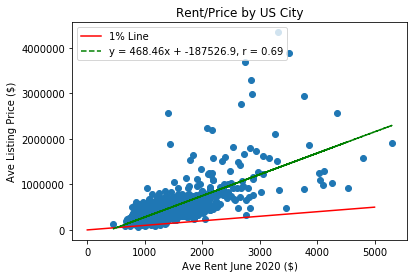

In [69]:
plt.scatter(rent_value_merge['Price_2020_06'],rent_value_merge['average_listing_price'])
plt.ylabel("Ave Listing Price ($)")
plt.xlabel("Ave Rent June 2020 ($)")
plt.title("Rent/Price by US City")

# 1% line, below are prospective
plt.plot([0,5000],[0,500000],"r", Label="1% Line")
plt.legend()

# trendline(rent_value_merge['Price_2020_06'],rent_value_merge['average_listing_price'])


slope, inter, r, p, std_err = st.linregress(rent_value_merge_drop['Price_2020_06'],rent_value_merge_drop['average_listing_price'])
fit = slope * rent_value_merge['Price_2020_06'] + inter
plt.plot(rent_value_merge['Price_2020_06'],fit,"--g",label="y = "+ str(round(slope,2)) + "x + "+ str(round(inter,1))+', r = ' + str(round(r,2)))
plt.legend()
slope

In [70]:
# List of cities to analyze further
prospective_cities = pd.DataFrame(rent_value_merge["1% Flag"].dropna())
prospective_cities

,1% Flag
City_State,
Calumet City_IL,0.010897
Camden_NJ,0.015162
Gary_IN,0.010710
Inkster_MI,0.013263
Park Forest_IL,0.012616


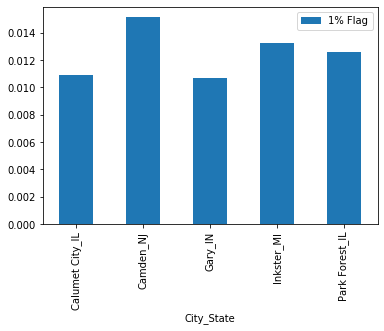

In [71]:
prospective_cities.plot.bar()